# Feature Selection
There are 32 features available in the cleaned data that can be used to build the model. Limiting the set of features in the prediction model is essential for good performance, but prediction accuracy may be degraded by the inadvertent removal of relevant features. Domain complexity often attributes of real-world problems and should be taken into consideration.
Features for the intended model are selected based on two criteria:
1. Relevancy to water quality goal. The goal of this project is to explore the possibility of predicting total nitrogen (tn) and total phosphorus with easily measurable features, to save and resources. We compared the cost of measuring each feature based on the [federal code of regulation approved testing procedures](https://www.ecfr.gov/cgi-bin/text-idx?SID=a6bb8a02b6d783f9356758b5ff0ed106&mc=true&node=pt40.25.136&rgn=div5).
2. Statistical test score for features relationship to target variables. A subset of features is selected based on their score on Pearson’s correlation to target variables. Pearson’s correlation is commonly used for continuous variables. Pearson’s correlation value varies from -1 to +1. Features with relatively highly Pearson’s correlation values (absolute value) are good predictors of the target variable. 

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew 
from sklearn.preprocessing import StandardScaler

pd.options.display.max_columns = 150
data = pd.read_csv('combined_2007&2012.csv')
data.head()

,Unnamed: 0,id,date,lat,lon,epa_reg,urban,lake_origin,area_ha,lake_area,lake_perim,sld,depth_max,elv,sample_depth,ph,tn,tp,turb,cl,cond,na,doc,k,mg,toc,ca,so4,sio2,chla,secmean,d18o_h2o,dd_h2o,e_i,rt,site_id_x
0,0,NLA06608-0001,2007-07-31,48.979029,-114.021840,Region_8,NO,NATURAL,66.293056,0.662931,3.178510,1.101247,8.3,1605.73,2.00,7.63,0.151,6.0,0.474,1.500000,96.28,0.010961,0.63,0.085911,19.938755,0.37,34.755350,0.965527,1.182,0.24,6.4,-15.73,-120.24,0.103,0.77,NaN
1,1,NLA06608-0002,2007-06-14,33.036064,-79.983791,Region_4,YES,MAN-MADE,14.437998,0.144380,1.743510,1.294393,2.3,4.90,1.10,6.05,0.695,36.0,3.550,178.008066,44.80,0.109875,14.02,0.099683,5.248823,15.90,8.517930,0.354807,1.695,3.84,0.55,1.24,2.32,0.366,0.26,NaN
2,2,NLA06608-0002,2007-07-23,33.036064,-79.983791,Region_4,YES,MAN-MADE,14.437998,0.144380,1.743510,1.294393,1.3,4.90,0.80,5.92,0.507,25.0,4.430,183.141558,42.87,0.092737,13.80,0.065581,5.147233,16.34,8.191085,0.281070,1.988,20.88,0.45,2.47,5.70,0.467,0.33,NaN
3,3,NLA06608-0003,2007-08-29,28.047742,-97.859866,Region_6,YES,NATURAL,5.701737,0.057017,1.265008,1.494462,2.5,17.60,1.40,8.47,0.738,43.0,7.670,4889.143422,1089.00,7.172756,6.00,3.789272,64.428456,6.75,128.617250,21.451106,45.248,16.96,0.71,-0.01,-4.84,0.204,0.17,NaN
4,4,NLA06608-0003,2007-09-06,28.047742,-97.859866,Region_6,YES,NATURAL,5.701737,0.057017,1.265008,1.494462,2.4,17.60,0.94,8.54,0.843,50.0,9.530,5113.606770,1120.00,7.142308,5.87,3.609580,64.313321,7.46,124.251000,20.717201,7.900,12.86,0.49,-0.66,-4.70,0.181,0.15,NaN


In [108]:
del data['Unnamed: 0']
del data['site_id_x']

###  Feature data type

In [99]:
data.dtypes.value_counts()

float64    28
object      7
dtype: int64

### Explore non-numeric features 

In [100]:
non_numeric_features = data[data.select_dtypes(include=['object']).columns]
non_numeric_features.head()

,id,date,epa_reg,urban,lake_origin,chla,secmean
0,NLA06608-0001,2007-07-31,Region_8,NO,NATURAL,0.24,6.4
1,NLA06608-0002,2007-06-14,Region_4,YES,MAN-MADE,3.84,0.55
2,NLA06608-0002,2007-07-23,Region_4,YES,MAN-MADE,20.88,0.45
3,NLA06608-0003,2007-08-29,Region_6,YES,NATURAL,16.96,0.71
4,NLA06608-0003,2007-09-06,Region_6,YES,NATURAL,12.86,0.49


'secmean' is listed as an object type though it represents continuous numeric data. This is likely due to data transformation problem.

In [101]:
data['secmean'] = pd.to_numeric(data['secmean'], errors = 'coerce')
data['chla'] = pd.to_numeric(data['chla'], errors = 'coerce')

In [102]:
data.dtypes.value_counts()

float64    30
object      5
dtype: int64

In [104]:
data.select_dtypes(include=('object')).columns

Index(['id', 'date', 'epa_reg', 'urban', 'lake_origin'], dtype='object')

In [16]:
# Save combined file 
data.to_csv('combined_2007&2012.csv', index=False)

#### Select numeric features

In [7]:
features = data.select_dtypes(include = ['float', 'int']).columns
features

Index(['lat', 'lon', 'area_ha', 'lake_perim', 'elv', 'ph', 'tn', 'tp', 'turb',
       'cl', 'cond', 'na', 'doc', 'k', 'mg', 'ca', 'so4', 'sio2', 'chla',
       'secmean', 'd18o_h2o', 'dd_h2o', 'e_i', 'rt'],
      dtype='object')

Latitude and longitude columns are not useful.

In [8]:
features = ['area_ha', 'lake_perim', 'elv', 'ph', 'turb', 'cl', 'cond', 'na', 'doc', 'k', 
                    'mg', 'ca', 'so4', 'sio2', 'chla', 'secmean', 'd18o_h2o', 'dd_h2o', 'e_i', 'rt']
targets = ['tn', 'tp']

In [9]:
# save data
data[features].to_csv('features.csv', index=False)
data[targets].to_csv('targets.csv', index=False)

#### Filter features based on Pearson's Correlation

In [10]:
del data['Unnamed: 0']

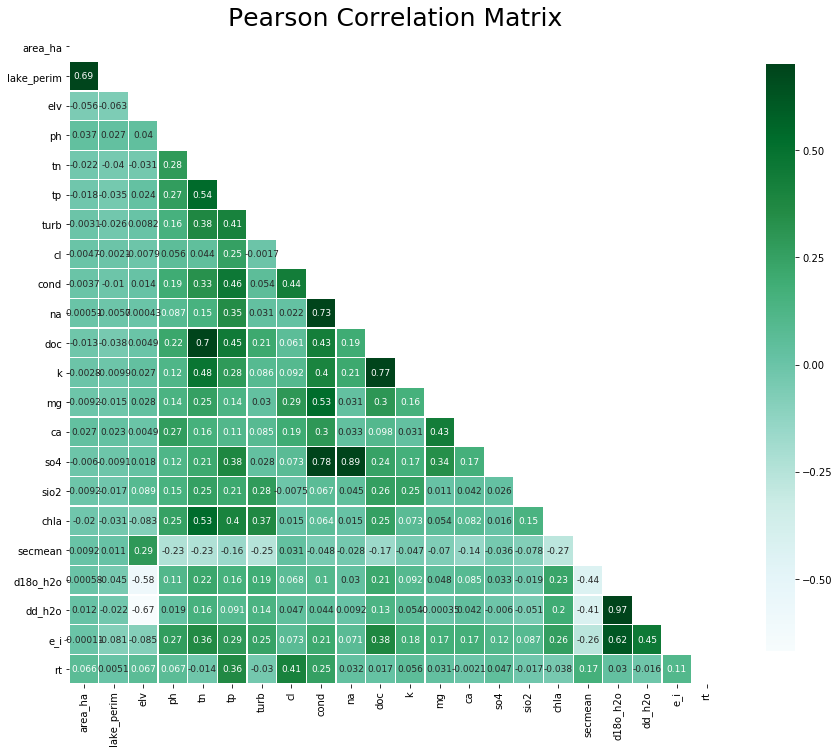

In [11]:
import seaborn as sns

dataset = data.drop(['lat', 'lon'], axis = 1)

fig, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

mask = np.zeros_like(dataset.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

sns.heatmap(dataset.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", 
            linecolor='w',annot=True,annot_kws={"size":9},mask = mask,cbar_kws={"shrink": .9})

In [12]:
abs_corr_coeffs_tn = data.corr()['tn'].abs().sort_values(ascending=False)
abs_corr_coeffs_tp = data.corr()['tp'].abs().sort_values(ascending=False)

#### Columns with a correlation coefficient of larger than 0.4 (arbitrary, to be experimented later!)

In [13]:
abs_corr_coeffs_tn[abs_corr_coeffs_tn > 0.2]

tn          1.000000
doc         0.697455
tp          0.535672
chla        0.530978
k           0.484228
turb        0.377628
e_i         0.363015
cond        0.328257
ph          0.284322
mg          0.252558
sio2        0.252533
secmean     0.230577
d18o_h2o    0.222284
so4         0.210891
Name: tn, dtype: float64

In [14]:
abs_corr_coeffs_tp[abs_corr_coeffs_tp > 0.2]

tp      1.000000
tn      0.535672
cond    0.460879
doc     0.449433
turb    0.409627
chla    0.400882
so4     0.380975
rt      0.364652
na      0.348874
e_i     0.289959
k       0.284106
ph      0.269193
cl      0.251848
sio2    0.208209
Name: tp, dtype: float64

The goal of this project is to predict total nitrogen and total phosphorus using relatively cost-effective and easily measurable features. After a thorough examination of testing procedures of features (at least correlated to target variables > 0.2) using [Code of Federal Regulation](https://www.ecfr.gov/cgi-bin/text-idx?SID=a6bb8a02b6d783f9356758b5ff0ed106&mc=true&node=pt40.25.136&rgn=div5), features are ranked as follows:

In [15]:
feature_rank = {1:'ph', 2:'turb', 3:'cond', 4:'secmean', 5: 'doc', 6:'k', 7:'mg', 
                8:'so4', 9:'cl', 10: 'chla', 11: 'sio2', 11:'d18o_h2o', 13: 'dd_h2o', 14: 'e_i', 15: 'rt'}

## Analyze the Target Feature¶

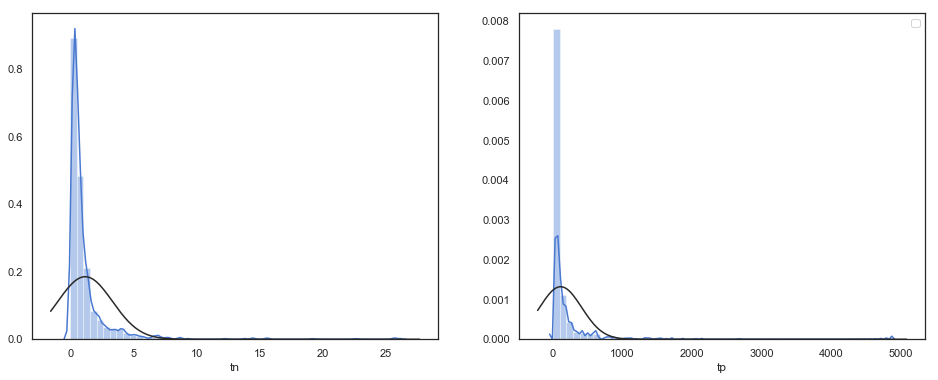

In [174]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

sns.distplot(data['tn'], fit=norm, ax=axes[0])
(mu, sigma) = norm.fit(data['tn'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

sns.distplot(data['tp'], fit=norm, ax=axes[1])
(mu1, sigma1) = norm.fit(data['tp'])

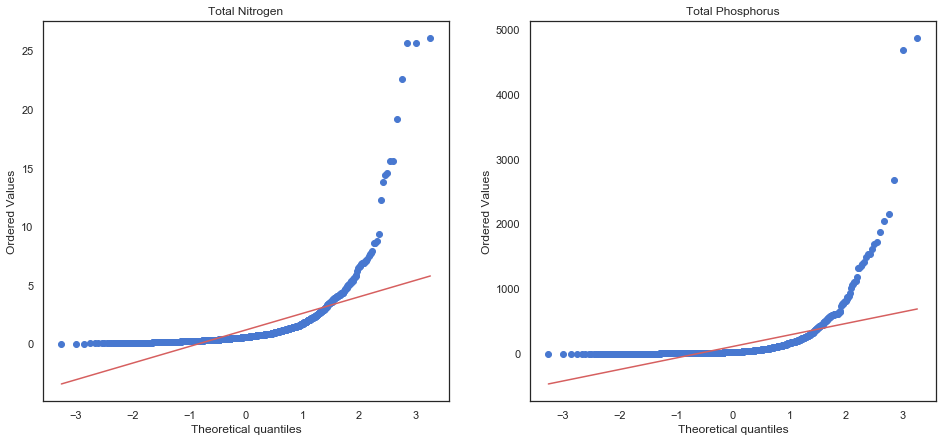

In [176]:
#Get also the QQ-plot
fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(121)
res = stats.probplot(data['tn'], plot=ax1)
plt.title('Total Nitrogen')

ax2 = fig.add_subplot(122)

res = stats.probplot(data['tp'], plot=ax2)
plt.title('Total Phosphorus')
plt.show()

In [163]:
#skewness and kurtosis
print("Total Nitrogen Skewness: %f" % data['tn'].skew())
print("Total Nitrogen Kurtosis: %f" % data['tn'].kurt())

Total Nitrogen Skewness: 6.569361
Total Nitrogen Kurtosis: 58.874655


In [164]:
#skewness and kurtosis
print("Total Phosphorus Skewness: %f" % data['tp'].skew())
print("Total Phosphorus Kurtosis: %f" % data['tp'].kurt())

Total Phosphorus Skewness: 8.343294
Total Phosphorus Kurtosis: 102.704318


The target variables;
+ The probability distribution for the total nitrogen and phosphorus data is right-skewed. 
+ Q-Q plots do not lie on a straight diagonal line
+ The skewness and Kurtosis values deviate much from normal univariate distribution (between -2 and +2)
These pieces of evidence suggest the dependent variables are not normally distributed.

### Check Multicollinearity

Features highly correlated with each other as it affects the interpretability of a model as regression coefficients are not uniquely determined. Here, feature multicollinearity evaluated using a variance inflation factor.

The variance inflation factor is defined as VIF = 1/T, where T is tolerance T = 1 – R². With VIF > 10 there is an indication that multicollinearity may be present; with VIF > 100 there is certainly multicollinearity among the variables.  

In [180]:
df= pd.read_csv('features.csv')
df_cor = df.corr()
vifs = pd.Series(np.linalg.inv(df.corr().values).diagonal(), index=df_cor.index)
vifs.sort_values()

sio2           1.187343
turb           1.307774
ph             1.323534
chla           1.332954
ca             1.386860
secmean        1.432147
rt             1.481038
area_ha        1.957065
lake_perim     1.961004
cl             2.068618
elv            2.130777
k              3.009489
e_i            3.555614
doc            3.615904
mg             4.256526
so4            9.477203
cond          12.087678
na            15.292788
dd_h2o        38.754032
d18o_h2o      45.204643
dtype: float64

The VIF values are between 10 and 100. There is no strong evidence for the presence of multicollinearity according to our criteria. Therefore, all features will be considered.

## Check Outliers

Outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviors. To establish a threshold for defining outliers, the data is standardized to have a mean of 0 and a standard deviation of 1.

In [190]:
#standardizing data
tn_scaled = StandardScaler().fit_transform(data['tn'][:,np.newaxis]);
low_range_tn = tn_scaled[tn_scaled[:,0].argsort()][:10]
high_range_tn = tn_scaled[tn_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution for Total Nitrogen:' + '\n' + '-'*52)
print(low_range_tn)
print('\nouter range (high) of the distribution Total Nitrogen:'+  '\n' + '-'*52)
print(high_range_tn)
tp_scaled = StandardScaler().fit_transform(data['tp'][:,np.newaxis]);
low_range_tp = tp_scaled[tn_scaled[:,0].argsort()][:10]
high_range_tp= tp_scaled[tn_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution for Total Phosphorus:' + '\n' + '-'*52)
print(low_range_tp)
print('\nouter range (high) of the distribution Total Phosphorus:'+  '\n' + '-'*52)
print(high_range_tp)

outer range (low) of the distribution for Total Nitrogen:
----------------------------------------------------
[[-0.54683053]
 [-0.5407978 ]
 [-0.53662129]
 [-0.53615723]
 [-0.53244478]
 [-0.53198072]
 [-0.53105261]
 [-0.53058855]
 [-0.52873233]
 [-0.5268761 ]]

outer range (high) of the distribution Total Nitrogen:
----------------------------------------------------
[[ 5.86642985]
 [ 6.13326232]
 [ 6.19730211]
 [ 6.67295999]
 [ 6.70173149]
 [ 8.36073336]
 [ 9.94455808]
 [11.3483289 ]
 [11.35993031]
 [11.56272298]]
outer range (low) of the distribution for Total Phosphorus:
----------------------------------------------------
[[-0.3710165 ]
 [-0.34117562]
 [-0.3643852 ]
 [-0.3710165 ]
 [-0.3643852 ]
 [-0.3710165 ]
 [-0.3710165 ]
 [-0.3643852 ]
 [-0.36106954]
 [-0.3643852 ]]

outer range (high) of the distribution Total Phosphorus:
----------------------------------------------------
[[4.02222381]
 [1.10776477]
 [3.19331054]
 [4.98707885]
 [3.55140107]
 [3.12699748]
 [2.51691732]
 [6.7

+  The low range values are not too far from 0.
+ The high range values are far from 0 with a maximum 11.5 on tn and 4.5 tp data. 
For now, these will be considered as an outlier but should be experimented on this later in the modeling exercise.